In [ ]:
pip install pandas scikit-learn nltk PyMuPDF


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 55.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 103.9 MB/s eta 0:00:00


In [ ]:
import fitz  # PyMuPDF
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn.functional as F

# Ensure stopwords are downloaded
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Function to extract text from PDF
def extract_text_from_pdf(pdf_path):
    document = fitz.open(pdf_path)
    text = ""
    for page_num in range(len(document)):
        page = document.load_page(page_num)
        text += page.get_text()
    return text

# Function to preprocess text
def preprocess(text):
    text = re.sub(r'\W', ' ', text)
    text = text.lower()
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# Expanded sample data
data = {
    'resume': [
        "Experienced software developer with knowledge of Python and Java.",
        "Project manager with 5 years of experience in IT projects.",
        "Data scientist proficient in Python, R, and machine learning techniques.",
        "High school teacher with experience in teaching mathematics and science.",
        "Business manager with experience in corporate strategy and operations.",
        "Software engineer with a background in developing mobile applications.",
        "Teacher with expertise in history and social studies.",
        "Financial analyst skilled in market analysis and investment strategies.",
        "Mechanical engineer with experience in automotive design and manufacturing.",
        "Digital marketing specialist with a focus on social media and SEO.",
        "Civil engineer with expertise in infrastructure and urban development projects.",
        "Content writer with a passion for creating engaging online content.",
        "Electrical engineer experienced in designing and testing electronic systems.",
        "Customer service representative with a strong focus on client satisfaction.",
        "Nurse with experience in patient care and hospital administration.",
        "HR manager with a background in recruitment and employee relations.",
        "Graphic designer skilled in Adobe Creative Suite and visual storytelling.",
        "Web developer with expertise in front-end technologies and UX/UI design.",
        "Supply chain manager with experience in logistics and inventory management.",
        "Marketing manager with a background in brand management and advertising.",
        "Assist in the development and execution of marketing campaigns. Coordinate with internal and external stakeholders to ensure timely delivery of marketing materials.",
        "Analyze large datasets to extract insights and inform business decisions. Develop and maintain dashboards and reports for stakeholders.",
        "Provide exceptional customer service through phone, email, and chat channels. Resolve customer inquiries and complaints in a timely manner.",
        "Assist customers in selecting products and services. Meet and exceed sales targets through effective communication and product knowledge.",
        "Lead cross-functional teams to deliver projects on time and within budget. Develop project plans, allocate resources, and track progress.",
        "Conduct financial analysis and modeling to support strategic decision-making. Prepare reports and presentations for senior management.",
        "Manage recruitment and onboarding processes. Administer employee benefits and assist with performance management.",
        "Provide direct patient care in hospital settings. Administer medications, monitor vital signs, and collaborate with healthcare team members.",
        "Create visual concepts and designs for print and digital media. Collaborate with clients to understand their design needs and objectives.",
        "Design and develop websites and web applications using HTML, CSS, and JavaScript. Ensure websites are responsive and user-friendly.",
        "Create engaging and informative content for websites, blogs, and social media platforms. Conduct research and adhere to brand guidelines.",
        "Oversee day-to-day operations and ensure efficient workflow. Develop and implement policies and procedures to optimize productivity.",
        "Test software applications to identify defects and ensure quality. Develop test plans and document test results.",
        "Provide technical support to end-users for hardware and software issues. Troubleshoot and resolve technical problems in a timely manner.",
        "Analyze business processes and requirements to identify opportunities for improvement. Develop business cases and propose solutions.",
        "Develop and implement social media strategies to increase brand awareness and engagement. Monitor social media channels and analyze performance metrics.",
        "Assist lawyers with legal research, drafting documents, and case management. Maintain organized legal files and databases.",
        "Define product vision and strategy based on market research and customer feedback. Manage product development lifecycle from concept to launch.",
        "Design and oversee the construction of buildings and structures. Create architectural plans and ensure compliance with building codes and regulations.",
        "Develop and execute test cases to identify software defects. Collaborate with developers to resolve issues and ensure software quality.",
        "Provide personalized financial advice and planning services to clients. Analyze financial data and develop customized financial plans.",
        "Create user-centered designs for digital products and interfaces. Conduct user research and usability testing to inform design decisions.",
        "Analyze marketing data and metrics to evaluate campaign performance. Generate insights and recommendations to optimize marketing strategies.",
        "Prepare and maintain financial records, including balance sheets, income statements, and tax returns. Ensure compliance with accounting standards and regulations.",
        "Design and implement network infrastructure to support business operations. Troubleshoot and resolve network issues to ensure uptime and reliability.",
        "Assist project managers in planning and executing projects. Coordinate project activities, resources, and stakeholders.",
        "Conduct scientific research and experiments to advance knowledge in a specific field. Analyze and interpret experimental data.",
        "Install, configure, and maintain computer systems and servers. Monitor system performance and troubleshoot technical issues.",
        "Design and oversee the architecture of software systems and applications. Define technical requirements and provide guidance to development teams.",
        "Develop and implement brand strategies to position products and services in the market. Monitor brand performance and consumer trends.",
        "Develop solutions to environmental problems, such as pollution control and resource conservation. Conduct environmental impact assessments.",
        "Lead sales teams to achieve revenue targets and business objectives. Develop sales strategies and coach team members to improve performance.",
        "Create user manuals, technical documentation, and instructional guides for software products and systems."
    ],
    'category': [
        "Software Engineer",
        "Project Manager",
        "Data Scientist",
        "High School Teacher",
        "Business Manager",
        "Software Engineer",
        "Teacher",
        "Financial Analyst",
        "Mechanical Engineer",
        "Digital Marketing Specialist",
        "Civil Engineer",
        "Content Writer",
        "Electrical Engineer",
        "Customer Service Representative",
        "Nurse",
        "HR Manager",
        "Graphic Designer",
        "Web Developer",
        "Supply Chain Manager",
        "Marketing Manager",
        "Marketing Coordinator",
        "Data Analyst",
        "Customer Service Representative",
        "Sales Associate",
        "Project Manager",
        "Financial Analyst",
        "Human Resources Specialist",
        "Registered Nurse",
        "Graphic Designer",
        "Web Developer",
        "Content Writer",
        "Operations Manager",
        "Quality Assurance Analyst",
        "IT Support Specialist",
        "Business Analyst",
        "Social Media Manager",
        "Legal Assistant",
        "Product Manager",
        "Architect",
        "Software Tester",
        "Financial Planner",
        "UX/UI Designer",
        "Marketing Analyst",
        "Accountant",
        "Network Engineer",
        "Project Coordinator",
        "Research Scientist",
        "Systems Administrator",
        "Software Architect",
        "Brand Manager",
        "Environmental Engineer",
        "Sales Manager",
        "Technical Writer"
    ]
}

df = pd.DataFrame(data)
df['resume'] = df['resume'].apply(preprocess)

X = df['resume']
y = df['category']

# Encode labels
label_mapping = {label: idx for idx, label in enumerate(df['category'].unique())}
y = df['category'].map(label_mapping)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
class ResumeDataset(Dataset):
    def __init__(self, resumes, labels, tokenizer, max_len):
        self.resumes = resumes
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.resumes)

    def __getitem__(self, index):
        resume = str(self.resumes[index])
        label = self.labels[index]

        encoding = self.tokenizer.encode_plus(
            resume,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LEN = 128
BATCH_SIZE = 8

train_dataset = ResumeDataset(
    resumes=X_train.to_numpy(),
    labels=y_train.to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)
test_dataset = ResumeDataset(
    resumes=X_test.to_numpy(),
    labels=y_test.to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LEN = 128
BATCH_SIZE = 8

train_dataset = ResumeDataset(
    resumes=X_train.to_numpy(),
    labels=y_train.to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)
test_dataset = ResumeDataset(
    resumes=X_test.to_numpy(),
    labels=y_test.to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
n_classes = len(label_mapping)
model = ResumeClassifier(n_classes)
model = model.to(device)  # Move the model to the appropriate device


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from transformers import AdamW, BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score

# Define your model class here
class ResumeClassifier(torch.nn.Module):
    def __init__(self, num_classes):
        super(ResumeClassifier, self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)

    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return output.logits

# Rest of your code
EPOCHS = 20
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_dataloader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

loss_fn = torch.nn.CrossEntropyLoss().to(device)

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

def eval_model(model, data_loader, loss_fn, device):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, labels)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define your train and test dataloaders here

for epoch in range(EPOCHS):
    train_acc, train_loss = train_epoch(model, train_dataloader, loss_fn, optimizer, device, scheduler)
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(model, test_dataloader, loss_fn, device)
    print(f'Validation loss {val_loss} accuracy {val_acc}')

# Evaluate the model on test data
y_pred = []
y_true = []

model.eval()
with torch.no_grad():
    for d in test_dataloader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)

        y_pred.extend(preds)
        y_true.extend(labels)

y_pred = torch.stack(y_pred).cpu()
y_true = torch.stack(y_true).cpu()

accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy:.3f}')


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/20
Train loss 2.515685717264811 accuracy 0.7857142857142857
Validation loss 3.9732861518859863 accuracy 0.09090909090909091
Epoch 2/20
Train loss 2.2761247754096985 accuracy 0.8333333333333334
Validation loss 3.9897741079330444 accuracy 0.0
Epoch 3/20
Train loss 2.026467283566793 accuracy 0.8095238095238095
Validation loss 4.256460905075073 accuracy 0.0
Epoch 4/20
Train loss 1.7107500433921814 accuracy 0.9285714285714286
Validation loss 4.058741092681885 accuracy 0.18181818181818182
Epoch 5/20
Train loss 1.6105007926623027 accuracy 0.9523809523809523
Validation loss 4.0556652545928955 accuracy 0.09090909090909091
Epoch 6/20
Train loss 1.4507220188776653 accuracy 0.9285714285714286
Validation loss 4.1301000118255615 accuracy 0.09090909090909091
Epoch 7/20
Train loss 1.2179088989893596 accuracy 0.9761904761904762
Validation loss 4.1554917097091675 accuracy 0.09090909090909091
Epoch 8/20
Train loss 1.117198387781779 accuracy 1.0
Validation loss 4.204435110092163 accuracy 0.0909090

In [ ]:
pip install pypdf2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 4.5 MB/s eta 0:00:00


In [ ]:
import PyPDF2
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.corpus import stopwords

# Download NLTK stopwords if not already downloaded
nltk.download('stopwords')

# Function to extract text from PDF using PdfReader
def extract_text_from_pdf(pdf_path):
    with open(pdf_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        text = ''
        for page in reader.pages:
            text += page.extract_text()
    return text

# Function to score the resume against a job description and identify matching/mismatching words
def score_resume(resume_text, job_description):
    # Initialize NLTK stopwords
    stop_words = set(stopwords.words('english'))

    vectorizer = TfidfVectorizer()
    vectors = vectorizer.fit_transform([resume_text, job_description])
    cosine_sim = cosine_similarity(vectors)
    relevance_score = cosine_sim[0, 1]

    # Tokenize resume text and job description after removing stopwords
    resume_words = set(word for word in resume_text.split() if word not in stop_words)
    job_words = set(word for word in job_description.split() if word not in stop_words)

    # Identify matching and mismatching words
    matching_words = resume_words.intersection(job_words)
    mismatching_words = job_words - resume_words

    return relevance_score, matching_words, mismatching_words

# Example job description
job_description = """
We are seeking a highly motivated and skilled Junior Data Scientist to join our dynamic team.
The ideal candidate will have a strong foundation in programming, particularly in Java, C, and Python, along with expertise in web development technologies such as HTML and CSS.
Additionally, proficiency in Microsoft Excel and knowledge of the Software Development Lifecycle are highly desirable. In this role, you will utilize machine learning techniques to develop and implement data-driven solutions,
collaborate with cross-functional teams to gather and analyze data from various sources, design and implement algorithms to extract insights and patterns from complex datasets, develop and maintain predictive models to support decision-making
processes, conduct exploratory data analysis to identify trends and opportunities for optimization, participate in code reviews, and contribute to the continuous improvement of data science methodologies. Effective communication and collaboration with stakeholders
at all levels will be essential for success in this position.
"""

# Specify the path to the resume PDF file
pdf_path = 'mercy resume.pdf'

# Extract text from the specified PDF resume
resume_text = extract_text_from_pdf(pdf_path)

# Score the resume against the job description and identify matching/mismatching words
relevance_score, matching_words, mismatching_words = score_resume(resume_text, job_description)
print(f'The relevance score of the resume to the job description is: {relevance_score:.2f}')
print(f'Matching words in the job description: {matching_words}')
print(f'Mismatching words in the job description: {mismatching_words}')


The relevance score of the resume to the job description is: 0.31
Matching words in the job description: {'development', 'learning', 'Development', 'machine', 'Lifecycle', 'The', 'web', 'Microsoft', 'Software', 'improvement', 'data', 'Excel', 'science'}
Mismatching words in the job description: {'programming,', 'analyze', 'team.', 'Python,', 'code', 'trends', 'analysis', 'predictive', 'extract', 'cross-functional', 'patterns', 'collaboration', 'techniques', 'seeking', 'design', 'conduct', 'participate', 'We', 'ideal', 'join', 'Additionally,', 'along', 'sources,', 'exploratory', 'Junior', 'decision-making', 'optimization,', 'models', 'collaborate', 'levels', 'identify', 'utilize', 'maintain', 'In', 'Data', 'knowledge', 'solutions,', 'insights', 'communication', 'develop', 'data-driven', 'teams', 'contribute', 'Effective', 'foundation', 'essential', 'processes,', 'continuous', 'skilled', 'implement', 'Java,', 'algorithms', 'proficiency', 'highly', 'HTML', 'expertise', 'opportunities', 'v

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import torch
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity
import PyPDF2

# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()

# Function to encode text using BERT tokenizer and model
def encode_text(text):
    inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state[:, 0, :]
    return embeddings

# Function to score the resume against a job description
def score_resume(resume_text, job_description):
    resume_embeddings = encode_text(resume_text)
    job_embeddings = encode_text(job_description)
    cosine_sim = cosine_similarity(resume_embeddings, job_embeddings)
    relevance_score = cosine_sim[0, 0]  # Compare the resume with the job description
    return relevance_score

# Specify the path to the resume PDF file
pdf_path = 'mercy resume.pdf'

# Extract text from the specified PDF resume
with open(pdf_path, 'rb') as file:
    reader = PyPDF2.PdfReader(file)
    resume_text = ''
    for page in reader.pages:
        resume_text += page.extract_text()

# Example job description
job_description = """
We are seeking a highly motivated and skilled Junior Data Scientist to join our dynamic team.
The ideal candidate will have a strong foundation in programming, particularly in Java, C, and Python, along with expertise in web development technologies such as HTML and CSS.
Additionally, proficiency in Microsoft Excel and knowledge of the Software Development Lifecycle are highly desirable. In this role, you will utilize machine learning techniques to develop and implement data-driven solutions,
collaborate with cross-functional teams to gather and analyze data from various sources, design and implement algorithms to extract insights and patterns from complex datasets, develop and maintain predictive models to support decision-making
processes, conduct exploratory data analysis to identify trends and opportunities for optimization, participate in code reviews, and contribute to the continuous improvement of data science methodologies. Effective communication and collaboration with stakeholders
at all levels will be essential for success in this position.
"""

# Score the resume against the job description
relevance_score = score_resume(resume_text, job_description)
print(f'Relevance Score: {relevance_score:.2f}')


Relevance Score: 0.78


In [ ]:
import torch
from transformers import BertTokenizer, BertModel
import PyPDF2
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Download NLTK stopwords if not already downloaded
nltk.download('stopwords')

# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()

# Function to extract text from PDF using PdfReader
def extract_text_from_pdf(pdf_path):
    with open(pdf_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        text = ''
        for page in reader.pages:
            text += page.extract_text()
    return text

# Function to encode text using BERT tokenizer and model
def encode_text(text):
    inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1)  # Use mean pooling to get sentence embeddings
    return embeddings

# Function to score the resume against a job description
def score_resume(resume_text, job_description):
    resume_embedding = encode_text(resume_text)
    job_embedding = encode_text(job_description)
    cosine_sim = cosine_similarity(resume_embedding, job_embedding)
    relevance_score = cosine_sim[0, 0]
    return relevance_score

# Example job description
job_description = """
We are seeking a highly motivated and skilled Junior Data Scientist to join our dynamic team.
The ideal candidate will have a strong foundation in programming, particularly in Java, C, and Python, along with expertise in web development technologies such as HTML and CSS.
Additionally, proficiency in Microsoft Excel and knowledge of the Software Development Lifecycle are highly desirable. In this role, you will utilize machine learning techniques to develop and implement data-driven solutions,
collaborate with cross-functional teams to gather and analyze data from various sources, design and implement algorithms to extract insights and patterns from complex datasets, develop and maintain predictive models to support decision-making
processes, conduct exploratory data analysis to identify trends and opportunities for optimization, participate in code reviews, and contribute to the continuous improvement of data science methodologies. Effective communication and collaboration with stakeholders
at all levels will be essential for success in this position.
"""

# Specify the path to the resume PDF file
pdf_path = 'mercy resume.pdf'

# Extract text from the specified PDF resume
resume_text = extract_text_from_pdf(pdf_path)

# Score the resume against the job description
relevance_score = score_resume(resume_text, job_description)
print(f'Relevance Score: {relevance_score:.2f}')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Relevance Score: 0.81


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Relevance Score: 0.81


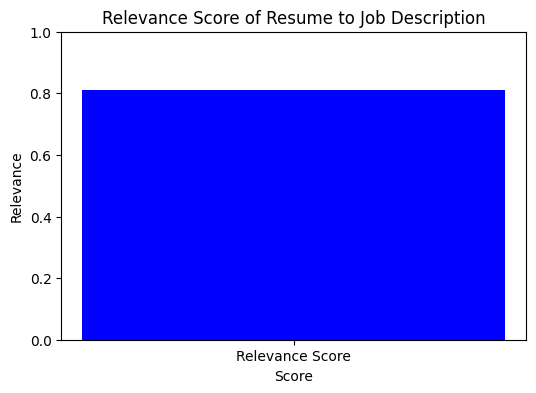

In [ ]:
import PyPDF2
import nltk
import matplotlib.pyplot as plt
import torch
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity

# Download NLTK stopwords if not already downloaded
nltk.download('stopwords')

# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()

# Function to extract text from PDF using PdfReader
def extract_text_from_pdf(pdf_path):
    with open(pdf_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        text = ''
        for page in reader.pages:
            text += page.extract_text()
    return text

# Function to encode text using BERT tokenizer and model
def encode_text(text):
    inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1)  # Use mean pooling to get sentence embeddings
    return embeddings

# Function to score the resume against a job description and identify matching/mismatching words
def score_resume(resume_text, job_description):
    resume_embedding = encode_text(resume_text)
    job_embedding = encode_text(job_description)
    cosine_sim = cosine_similarity(resume_embedding, job_embedding)
    relevance_score = cosine_sim[0, 0]
    return relevance_score

# Example job description
job_description = """
We are seeking a highly motivated and skilled Junior Data Scientist to join our dynamic team.
The ideal candidate will have a strong foundation in programming, particularly in Java, C, and Python, along with expertise in web development technologies such as HTML and CSS.
Additionally, proficiency in Microsoft Excel and knowledge of the Software Development Lifecycle are highly desirable. In this role, you will utilize machine learning techniques to develop and implement data-driven solutions,
collaborate with cross-functional teams to gather and analyze data from various sources, design and implement algorithms to extract insights and patterns from complex datasets, develop and maintain predictive models to support decision-making
processes, conduct exploratory data analysis to identify trends and opportunities for optimization, participate in code reviews, and contribute to the continuous improvement of data science methodologies. Effective communication and collaboration with stakeholders
at all levels will be essential for success in this position.
"""

# Specify the path to the resume PDF file
pdf_path = 'mercy resume.pdf'

# Extract text from the specified PDF resume
resume_text = extract_text_from_pdf(pdf_path)

# Score the resume against the job description
relevance_score = score_resume(resume_text, job_description)
print(f'Relevance Score: {relevance_score:.2f}')

# Plotting the relevance score
plt.figure(figsize=(6, 4))
plt.bar(['Relevance Score'], [relevance_score], color='blue')
plt.title('Relevance Score of Resume to Job Description')
plt.xlabel('Score')
plt.ylabel('Relevance')
plt.ylim(0, 1)
plt.show()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


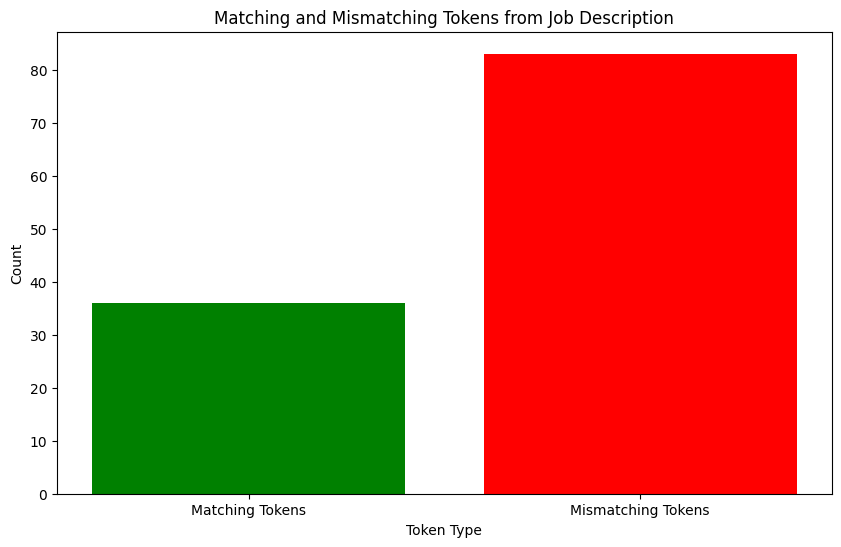

In [ ]:
import PyPDF2
import nltk
import matplotlib.pyplot as plt
import torch
from transformers import BertTokenizer, BertModel

# Download NLTK stopwords if not already downloaded
nltk.download('stopwords')

# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to extract text from PDF using PdfReader
def extract_text_from_pdf(pdf_path):
    with open(pdf_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        text = ''
        for page in reader.pages:
            text += page.extract_text()
    return text

# Function to tokenize text using BERT tokenizer
def tokenize_text(text):
    tokens = tokenizer.tokenize(text)
    return tokens

# Example job description
job_description = """
We are seeking a highly motivated and skilled Junior Data Scientist to join our dynamic team.
The ideal candidate will have a strong foundation in programming, particularly in Java, C, and Python, along with expertise in web development technologies such as HTML and CSS.
Additionally, proficiency in Microsoft Excel and knowledge of the Software Development Lifecycle are highly desirable. In this role, you will utilize machine learning techniques to develop and implement data-driven solutions,
collaborate with cross-functional teams to gather and analyze data from various sources, design and implement algorithms to extract insights and patterns from complex datasets, develop and maintain predictive models to support decision-making
processes, conduct exploratory data analysis to identify trends and opportunities for optimization, participate in code reviews, and contribute to the continuous improvement of data science methodologies. Effective communication and collaboration with stakeholders
at all levels will be essential for success in this position.
"""

# Specify the path to the resume PDF file
pdf_path = 'mercy resume.pdf'

# Extract text from the specified PDF resume
resume_text = extract_text_from_pdf(pdf_path)

# Tokenize job description and resume text
job_tokens = set(tokenize_text(job_description))
resume_tokens = set(tokenize_text(resume_text))

# Calculate matching and mismatching tokens
matching_tokens = job_tokens.intersection(resume_tokens)
mismatching_tokens = job_tokens - resume_tokens

# Plotting the matching and mismatching tokens
plt.figure(figsize=(10, 6))
plt.bar(['Matching Tokens', 'Mismatching Tokens'], [len(matching_tokens), len(mismatching_tokens)], color=['green', 'red'])
plt.title('Matching and Mismatching Tokens from Job Description')
plt.xlabel('Token Type')
plt.ylabel('Count')
plt.show()


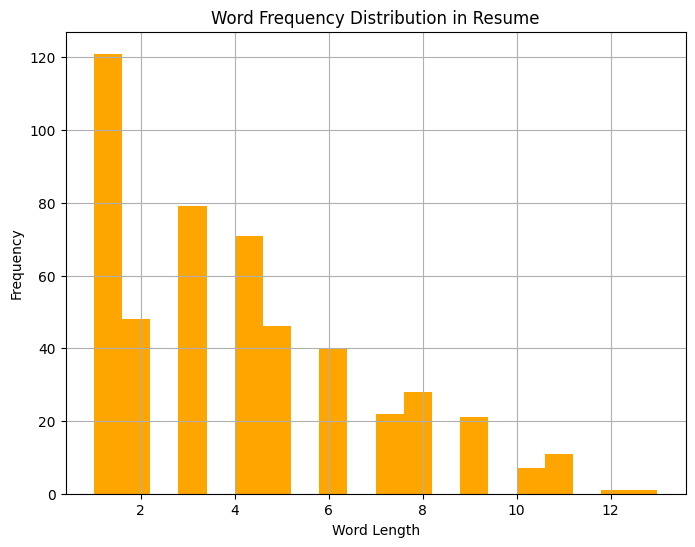

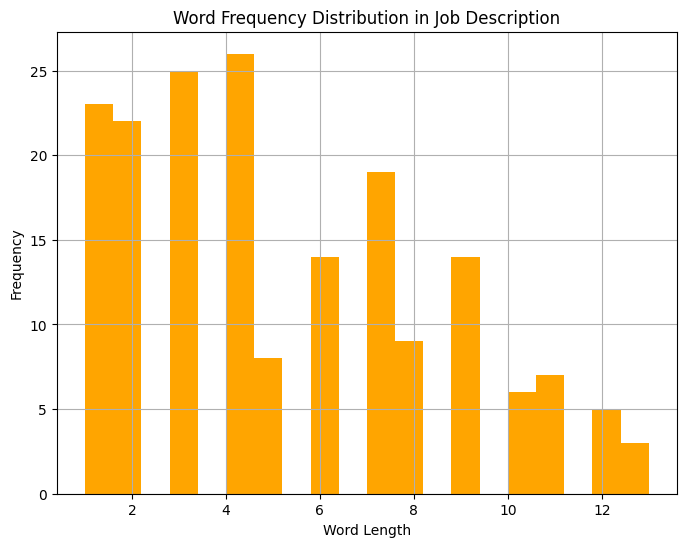

In [ ]:
from transformers import BertTokenizer

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to plot word frequency distribution
def plot_word_distribution(text, title):
    # Tokenize the text using BERT tokenizer
    tokenized_text = tokenizer.tokenize(text)

    # Convert tokens to lowercase
    tokenized_text = [token.lower() for token in tokenized_text]

    # Calculate word lengths
    word_lengths = [len(token) for token in tokenized_text]

    # Plot word frequency distribution
    plt.figure(figsize=(8, 6))
    plt.hist(word_lengths, bins=20, color='orange')
    plt.title(title)
    plt.xlabel('Word Length')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Example job description
job_description = """
We are seeking a highly motivated and skilled Junior Data Scientist to join our dynamic team.
The ideal candidate will have a strong foundation in programming, particularly in Java, C, and Python, along with expertise in web development technologies such as HTML and CSS.
Additionally, proficiency in Microsoft Excel and knowledge of the Software Development Lifecycle are highly desirable. In this role, you will utilize machine learning techniques to develop and implement data-driven solutions,
collaborate with cross-functional teams to gather and analyze data from various sources, design and implement algorithms to extract insights and patterns from complex datasets, develop and maintain predictive models to support decision-making
processes, conduct exploratory data analysis to identify trends and opportunities for optimization, participate in code reviews, and contribute to the continuous improvement of data science methodologies. Effective communication and collaboration with stakeholders
at all levels will be essential for success in this position.
"""

# Specify the path to the resume PDF file
pdf_path = 'mercy resume.pdf'

# Extract text from the specified PDF resume
resume_text = extract_text_from_pdf(pdf_path)

# Plotting word frequency distribution for resume
plot_word_distribution(resume_text, 'Word Frequency Distribution in Resume')

# Plotting word frequency distribution for job description
plot_word_distribution(job_description, 'Word Frequency Distribution in Job Description')


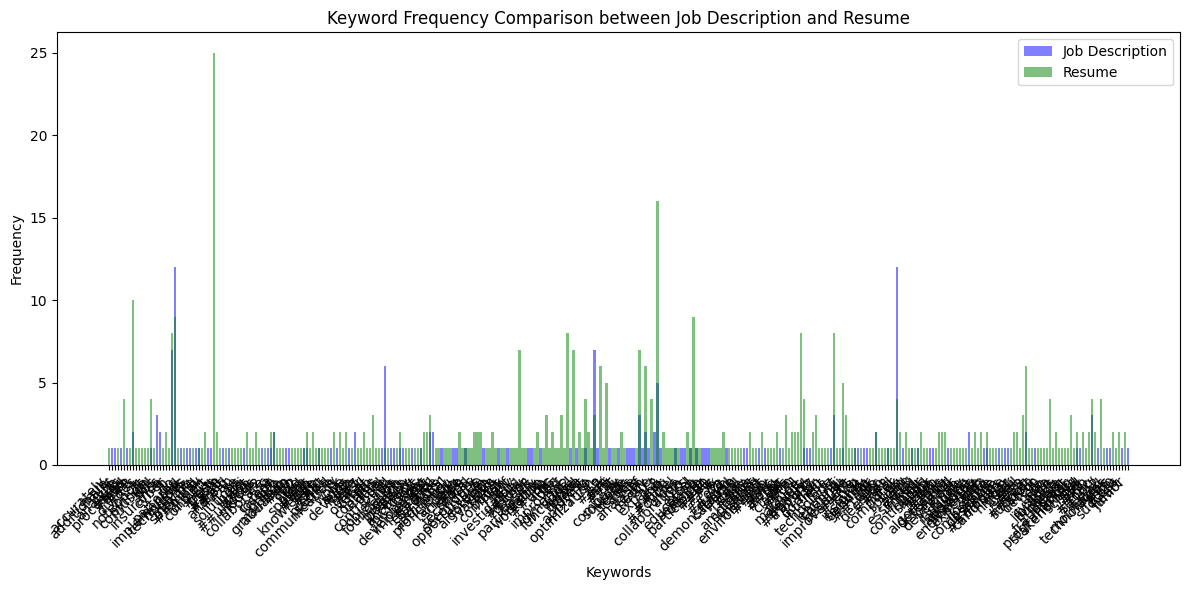

In [ ]:
from transformers import BertTokenizer
from collections import Counter
import re
import matplotlib.pyplot as plt

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to extract keywords from text using BERT tokenizer
def extract_keywords_bert(text):
    # Tokenize the text using BERT tokenizer
    tokens = tokenizer.tokenize(text)

    # Filter out stopwords and special tokens
    keywords = [token for token in tokens if token not in tokenizer.all_special_tokens]

    return keywords

# Function to plot keyword frequency
def plot_keyword_frequency_bert(job_keywords, resume_keywords):
    # Count occurrences of each keyword in job description and resume
    job_keyword_counts = Counter(job_keywords)
    resume_keyword_counts = Counter(resume_keywords)

    # Extract unique keywords
    all_keywords = set(job_keyword_counts.keys()).union(resume_keyword_counts.keys())

    # Prepare data for plotting
    job_counts = [job_keyword_counts[key] for key in all_keywords]
    resume_counts = [resume_keyword_counts[key] for key in all_keywords]
    keywords = list(all_keywords)

    # Plotting keyword frequency
    plt.figure(figsize=(12, 6))
    plt.bar(keywords, job_counts, color='blue', alpha=0.5, label='Job Description')
    plt.bar(keywords, resume_counts, color='green', alpha=0.5, label='Resume')
    plt.title('Keyword Frequency Comparison between Job Description and Resume')
    plt.xlabel('Keywords')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example job description
job_description = """
We are seeking a highly motivated and skilled Junior Data Scientist to join our dynamic team.
The ideal candidate will have a strong foundation in programming, particularly in Java, C, and Python, along with expertise in web development technologies such as HTML and CSS.
Additionally, proficiency in Microsoft Excel and knowledge of the Software Development Lifecycle are highly desirable. In this role, you will utilize machine learning techniques to develop and implement data-driven solutions,
collaborate with cross-functional teams to gather and analyze data from various sources, design and implement algorithms to extract insights and patterns from complex datasets, develop and maintain predictive models to support decision-making
processes, conduct exploratory data analysis to identify trends and opportunities for optimization, participate in code reviews, and contribute to the continuous improvement of data science methodologies. Effective communication and collaboration with stakeholders
at all levels will be essential for success in this position.
"""

# Specify the path to the resume PDF file
pdf_path = 'mercy resume.pdf'

# Extract text from the specified PDF resume
resume_text = extract_text_from_pdf(pdf_path)

# Extract keywords from job description and resume using BERT tokenizer
job_keywords_bert = extract_keywords_bert(job_description)
resume_keywords_bert = extract_keywords_bert(resume_text)

# Plotting keyword frequency comparison
plot_keyword_frequency_bert(job_keywords_bert, resume_keywords_bert)
